# Description
Train linear optical encoders for the extended cell-organelle dataset.

# Load Libraries

In [2]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms

In [3]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=600, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=500, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Data loaders

In [4]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]

In [ ]:
""" Prepare data loaders """
data = np.load('./EBI_Cells_grey_w_anomaly3.npz')
train_np = data['train_data_grey']
train_labels = data['train_labels']
val_np = data['val_data_grey']
val_labels = data['val_labels']
test_np = data['test_data_grey']
test_labels = data['test_labels']

transforms_digi = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_digi_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                              transforms.Lambda(lambda x: x.view(-1)), \
                                              transforms.Lambda(lambda x: x)])
kwargs = {}

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_labels.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_labels.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_labels.shape[0])), \
                                             batch_size=10000, drop_last=False)

train_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_np, train_labels, transforms_digi), 
    batch_sampler=train_sampler, **kwargs)

val_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(val_np, val_labels, transforms_digi), 
    batch_sampler=val_sampler, **kwargs)

test_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_np, test_labels, transforms_digi), 
    batch_sampler=test_sampler, **kwargs)

data_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(np.concatenate((test_np, val_np, train_np), axis=0), np.concatenate((test_labels, val_labels, train_labels), axis=0), transforms_digi), 
    batch_size=100000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_sampler=test_sampler, **kwargs)

# train_loader_phys_order = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(train_np, train_labels, transforms_phys), \
#     batch_size=3000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_size=505, shuffle=False, **kwargs)

In [ ]:
print(next(enumerate(data_loader))[1][0].shape)
print(next(enumerate(train_loader))[1][0].shape)
print(next(enumerate(val_loader))[1][0].shape)
print(next(enumerate(test_loader))[1][0].shape)

# NN Models

In [6]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out

def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.relu(torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50)

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [7]:
""" Definition of neural network structures """

coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

class OpticalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        modules = []
        modules.append(ONNLinear(Nunits[0], Nunits[1], zeros_init=False)) 
        for l in range(1, len(Nunits)-1):
            modules.append(ONNIntensifier(NL_func, self.coeffs))
            modules.append(ONNLinear(Nunits[l], Nunits[l+1], zeros_init=False)) 
        self.encoder_nn = nn.Sequential(*modules)
        compressed_size = Nunits[-1]
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.encoder_nn(x)
        y = self.digifc(x)
        return y

In [9]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[0]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [31]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
        if args.wandb:
            wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
    print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = []
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
    val_stats = {"val_loss": test_loss, "accuracy": accuracy}
    for i, hk in enumerate(hks):
        val_stats[f"fc{i+1}"] = wandb.Histogram(hks[i].output.cpu())      
    
    if epoch%1 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

    if args.wandb:
        wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [47]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    lr_factor0 = 0.0008
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/4, lr_factor0*2)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 0.0001, 0.001)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [300, 400, 500])
#     warmup_epochs = trial.suggest_categorical("warmup_eps", [18, 24, 30])
    #model_description = f"Autoencoder_QAT_ar5wd5_lr_{learning_rate:.3f}_{lr_decay:.2f}" + f"_m_{momentum:.2f}" + f"_wp_{warmup_epochs}"+ f"_v_{trial.number}"
    model_description = f"Classifier_20_b{batch_size}_AdamW_lr_{learning_rate:.6f}_bs_{batch_size}_betas_{beta1:.4f}_{beta2:.4f}" + f"_v_{trial.number}"

    # Instantiate a BNN model
    model = OpticalClassifier([100**2, 20])

    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
    if args.wandb:
        wandb.init(project=NAS_project_name, name=model_description, reinit=True)
        wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+50)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 30:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [48]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [ ]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [1,1,1]
rseeds = [15,306,921,213]

NAS_project_name = "Jun_30_fulcell_linear"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader, val_loader)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

In [46]:
ray.shutdown()

# Check inputs

In [20]:
%matplotlib notebook

<IPython.core.display.Javascript object>


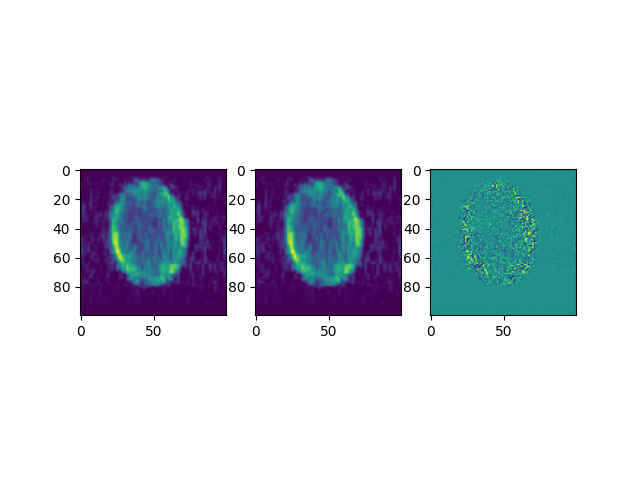

tensor(0)
tensor(1381.4630)


In [29]:
import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1,3)
idx = 30
B = next(enumerate(data_loader))[1]
axes[0].imshow(B[0][idx,:].view(100,-1))
axes[1].imshow(train_np[idx,:].reshape(100,-1))
axes[2].imshow(B[0][idx,:].view(100,-1)-train_np[idx,:].reshape(100,-1))
print(B[1][idx])
print(B[0][idx].sum())

# Check nonlinearity

<IPython.core.display.Javascript object>


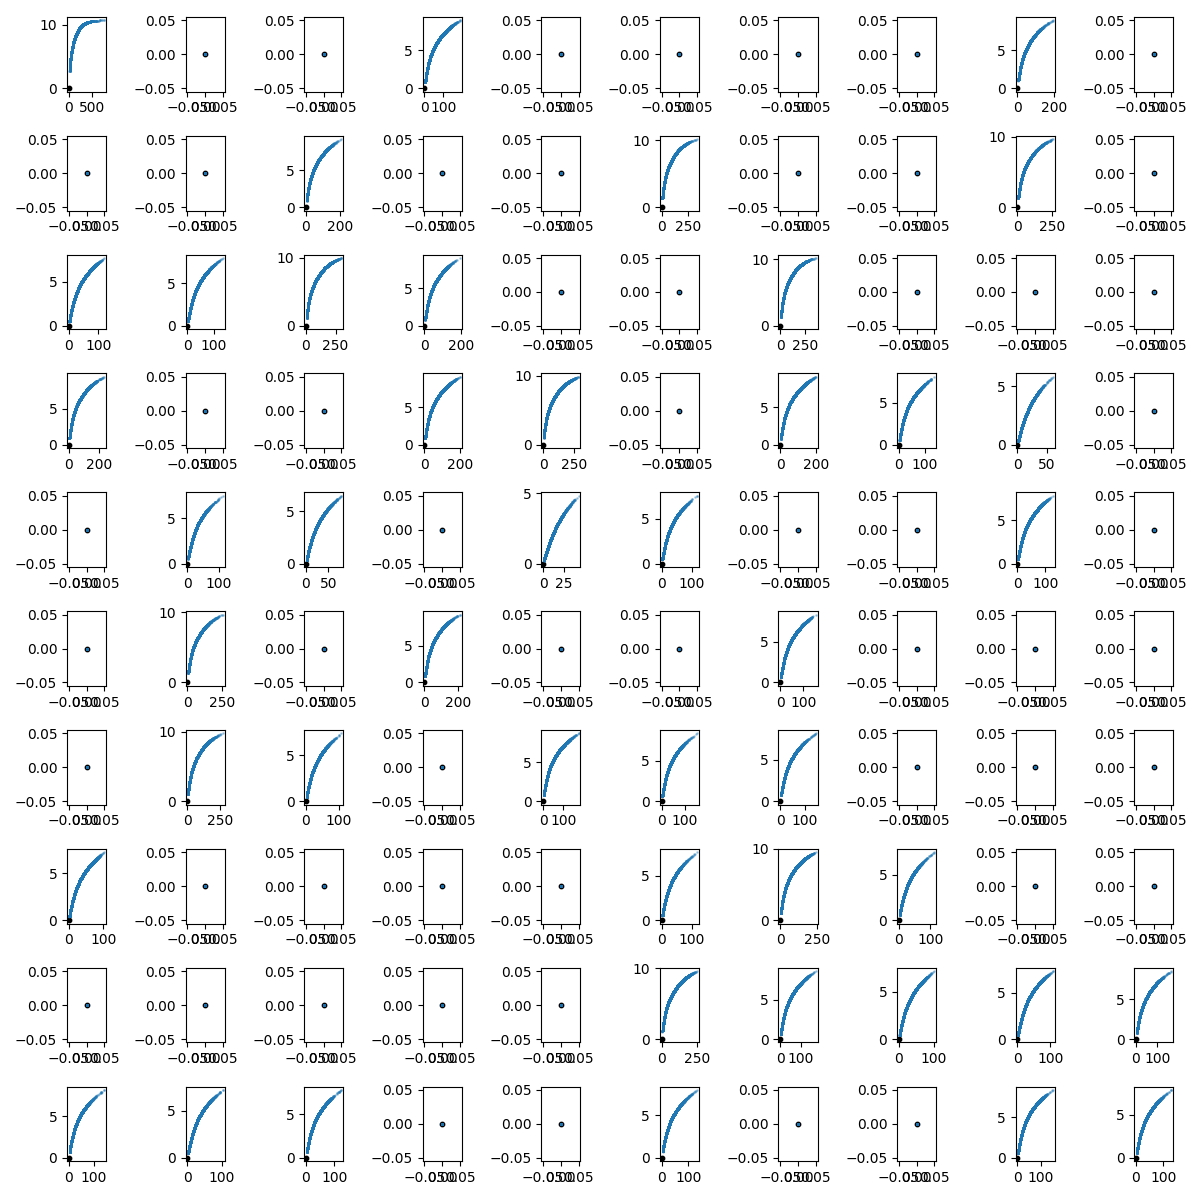

In [106]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(10, 10, figsize = (12, 12))
x0 = torch.arange(0, 400/10, 0.1)
# y0s = model.encoder_nn[1](x0.tile(100,1).T)
# p0s = np.ones((36,4))
# p0s[0,:] = [20, 4, 0, 10]
# p0s[3,:] = [10, 1/3, 1, 1]
# p0s[5,:] = [20, 1/3, 1, 1]
# p0s[8,:] = [100, 1/100, 0, 1]
# p0s[12,:] = [10, 1/2, 0, 1]
# p0s[19,:] = [10, 1/2, 0, 1]
# p0s[23,:] = [20, 1/2, 0, 1]
# p0s[33,:] = [10, 1/2, 0, 1]
# p0s[35,:] = [20, 1/2, 0, 1]
# p0s[:,1] = p0s[:,1]/100
# p0s[:,3] = p0s[:,3]/100
# T1_inv = lambda x: (x+7843.875)/2986.897
# T2_inv = lambda x: x/156575.98
# coeffs_new = np.zeros(p0s.shape)
for k in range(100):
    i = k//10
    j = k%10
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = hkfc1.output[:,k].detach().numpy()
#     y = model.encoder_nn[1](hkfc1.output[:,k]).detach().numpy()
    y = hkact1.output[:,k].detach().numpy()
    ax.scatter(x, y, s=1, alpha=0.3)
#     ax.set_xlabel('Input Intensity')
#     ax.set_ylabel('Output Intensity')
#     popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
#     print(popt)
#     coeffs_new[k,:] = popt
#     coeffs_new[k,0] = coeffs_new[k,0]*50
#     coeffs_new[k,2] = coeffs_new[k,2]*50
#     ax.plot(x0, func2(x0, *coeffs_new[k,:])/50, 'r--')
#     ax.plot(x0, func2(x0, *coeffs_orig[k,:])/50, 'b')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Test Runs

In [13]:
args.wandb = True

# model = digitalClassifier([100**2, 1000, 500, 10])
model = OpticalClassifier([100**2, 200, 10])

# with torch.no_grad():
#     model.encoder_nn[0].W_Opt.copy_(torch.tensor(H1/3.2))
#     model.encoder_nn[2].W_Opt.copy_(torch.tensor(H2/10))
#     model.encoder_nn[4].W_Opt.copy_(torch.tensor(H3/10))
    
# model.encoder_nn[0].W_Opt.requires_grad = False
# model.encoder_nn[2].W_Opt.requires_grad = False
# model.encoder_nn[4].W_Opt.requires_grad = False

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu
    
if args.wandb:
    wandb.init(project="Jun_16_H1", name="H1_reduced2_200_b128_AdamW_lr_0.001_betas_0.999_0.999", reinit=True)
    wandb.watch(model, log="all")

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1E-3, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
train_loader.batch_sampler.batch_size = 128
for epoch in range(1, 1000):
#     if epoch > 3000:
#          model.encoder_nn[0].W_Opt.requires_grad = True
    train(epoch, model, optimizer, criterion, train_loader)
    loss = test(epoch, model, criterion, test_loader)

accuracy,▁▄▅▆▇▇▇████████████
batch,███████████████████▁
train_loss,██▇▅▄▃▃▃▁▂▂▂▂▂▁▂▁▁▁▁
val_loss,█▅▄▃▂▂▁▁▁▁▁▁▁▂▂▂▃▃▃
accuracy,88.88889
batch,80
train_loss,0.04186
val_loss,0.4997


Train Epoch: 1 		Loss: 1.403870	Accuracy:  42.82%

Test set: Epoch 1, Average loss: 1.3930, Accuracy: 9028/17307(52%)

Train Epoch: 2 		Loss: 1.303144	Accuracy:  59.54%

Test set: Epoch 2, Average loss: 1.1639, Accuracy: 10903/17307(63%)

Train Epoch: 3 		Loss: 0.936793	Accuracy:  67.85%

Test set: Epoch 3, Average loss: 1.0072, Accuracy: 12190/17307(70%)

Train Epoch: 4 		Loss: 0.817925	Accuracy:  71.62%

Test set: Epoch 4, Average loss: 0.9305, Accuracy: 12490/17307(72%)

Train Epoch: 5 		Loss: 0.786286	Accuracy:  73.51%

Test set: Epoch 5, Average loss: 0.8787, Accuracy: 12823/17307(74%)

Train Epoch: 6 		Loss: 0.949694	Accuracy:  74.09%

Test set: Epoch 6, Average loss: 0.8558, Accuracy: 12838/17307(74%)

Train Epoch: 7 		Loss: 0.790427	Accuracy:  75.85%

Test set: Epoch 7, Average loss: 0.8141, Accuracy: 13176/17307(76%)

Train Epoch: 8 		Loss: 0.610850	Accuracy:  76.89%

Test set: Epoch 8, Average loss: 0.7979, Accuracy: 13149/17307(76%)

Train Epoch: 9 		Loss: 0.966841	Accuracy:


Train Epoch: 135 		Loss: 0.282412	Accuracy:  90.95%

Test set: Epoch 135, Average loss: 0.4789, Accuracy: 14743/17307(85%)

Train Epoch: 136 		Loss: 0.274679	Accuracy:  90.38%

Test set: Epoch 136, Average loss: 0.4925, Accuracy: 14614/17307(84%)

Train Epoch: 137 		Loss: 0.218801	Accuracy:  90.97%

Test set: Epoch 137, Average loss: 0.4632, Accuracy: 14875/17307(86%)

Train Epoch: 138 		Loss: 0.376302	Accuracy:  91.01%

Test set: Epoch 138, Average loss: 0.4727, Accuracy: 14827/17307(86%)

Train Epoch: 139 		Loss: 0.184556	Accuracy:  90.63%

Test set: Epoch 139, Average loss: 0.4823, Accuracy: 14740/17307(85%)

Train Epoch: 140 		Loss: 0.207829	Accuracy:  91.11%

Test set: Epoch 140, Average loss: 0.4708, Accuracy: 14792/17307(85%)

Train Epoch: 141 		Loss: 0.406101	Accuracy:  91.14%

Test set: Epoch 141, Average loss: 0.4728, Accuracy: 14781/17307(85%)

Train Epoch: 142 		Loss: 0.257270	Accuracy:  91.10%

Test set: Epoch 142, Average loss: 0.4731, Accuracy: 14805/17307(86%)

Train E

Train Epoch: 267 		Loss: 0.266092	Accuracy:  93.67%

Test set: Epoch 267, Average loss: 0.4532, Accuracy: 14946/17307(86%)

Train Epoch: 268 		Loss: 0.255398	Accuracy:  93.90%

Test set: Epoch 268, Average loss: 0.4516, Accuracy: 14937/17307(86%)

Train Epoch: 269 		Loss: 0.236943	Accuracy:  93.74%

Test set: Epoch 269, Average loss: 0.4439, Accuracy: 14977/17307(87%)

Train Epoch: 270 		Loss: 0.300201	Accuracy:  94.20%

Test set: Epoch 270, Average loss: 0.4430, Accuracy: 14968/17307(86%)

Train Epoch: 271 		Loss: 0.174271	Accuracy:  94.15%

Test set: Epoch 271, Average loss: 0.4446, Accuracy: 14949/17307(86%)

Train Epoch: 272 		Loss: 0.198435	Accuracy:  93.97%

Test set: Epoch 272, Average loss: 0.4568, Accuracy: 14922/17307(86%)

Train Epoch: 273 		Loss: 0.178705	Accuracy:  93.74%

Test set: Epoch 273, Average loss: 0.4524, Accuracy: 14904/17307(86%)

Train Epoch: 274 		Loss: 0.190106	Accuracy:  94.07%

Test set: Epoch 274, Average loss: 0.4486, Accuracy: 14941/17307(86%)

Train Ep

Train Epoch: 399 		Loss: 0.225919	Accuracy:  95.46%

Test set: Epoch 399, Average loss: 0.4411, Accuracy: 15044/17307(87%)

Train Epoch: 400 		Loss: 0.107018	Accuracy:  95.56%

Test set: Epoch 400, Average loss: 0.4535, Accuracy: 14971/17307(87%)

Train Epoch: 401 		Loss: 0.151964	Accuracy:  95.62%

Test set: Epoch 401, Average loss: 0.4516, Accuracy: 14956/17307(86%)

Train Epoch: 402 		Loss: 0.127738	Accuracy:  95.80%

Test set: Epoch 402, Average loss: 0.4481, Accuracy: 14972/17307(87%)

Train Epoch: 403 		Loss: 0.137888	Accuracy:  95.71%

Test set: Epoch 403, Average loss: 0.4577, Accuracy: 14873/17307(86%)

Train Epoch: 404 		Loss: 0.186910	Accuracy:  95.30%

Test set: Epoch 404, Average loss: 0.4444, Accuracy: 15056/17307(87%)

Train Epoch: 405 		Loss: 0.174124	Accuracy:  95.76%

Test set: Epoch 405, Average loss: 0.4421, Accuracy: 15013/17307(87%)

Train Epoch: 406 		Loss: 0.120888	Accuracy:  95.82%

Test set: Epoch 406, Average loss: 0.4474, Accuracy: 15015/17307(87%)

Train Ep

Train Epoch: 531 		Loss: 0.117311	Accuracy:  96.59%

Test set: Epoch 531, Average loss: 0.4487, Accuracy: 15049/17307(87%)

Train Epoch: 532 		Loss: 0.100997	Accuracy:  96.61%

Test set: Epoch 532, Average loss: 0.4550, Accuracy: 15031/17307(87%)

Train Epoch: 533 		Loss: 0.117564	Accuracy:  96.73%

Test set: Epoch 533, Average loss: 0.4564, Accuracy: 15054/17307(87%)

Train Epoch: 534 		Loss: 0.089684	Accuracy:  96.85%

Test set: Epoch 534, Average loss: 0.4509, Accuracy: 15015/17307(87%)

Train Epoch: 535 		Loss: 0.117149	Accuracy:  96.62%

Test set: Epoch 535, Average loss: 0.4450, Accuracy: 15084/17307(87%)

Train Epoch: 536 		Loss: 0.052114	Accuracy:  96.79%

Test set: Epoch 536, Average loss: 0.4437, Accuracy: 15050/17307(87%)

Train Epoch: 537 		Loss: 0.095141	Accuracy:  97.03%

Test set: Epoch 537, Average loss: 0.4467, Accuracy: 15036/17307(87%)

Train Epoch: 538 		Loss: 0.109503	Accuracy:  96.61%

Test set: Epoch 538, Average loss: 0.4540, Accuracy: 15010/17307(87%)

Train Ep

Train Epoch: 663 		Loss: 0.154487	Accuracy:  97.29%

Test set: Epoch 663, Average loss: 0.4595, Accuracy: 15010/17307(87%)

Train Epoch: 664 		Loss: 0.172888	Accuracy:  97.38%

Test set: Epoch 664, Average loss: 0.4599, Accuracy: 15076/17307(87%)

Train Epoch: 665 		Loss: 0.117643	Accuracy:  97.33%

Test set: Epoch 665, Average loss: 0.4603, Accuracy: 15076/17307(87%)

Train Epoch: 666 		Loss: 0.211302	Accuracy:  97.36%

Test set: Epoch 666, Average loss: 0.4544, Accuracy: 15086/17307(87%)

Train Epoch: 667 		Loss: 0.092771	Accuracy:  97.61%

Test set: Epoch 667, Average loss: 0.4628, Accuracy: 14995/17307(87%)

Train Epoch: 668 		Loss: 0.089951	Accuracy:  97.63%

Test set: Epoch 668, Average loss: 0.4625, Accuracy: 15015/17307(87%)

Train Epoch: 669 		Loss: 0.100221	Accuracy:  97.18%

Test set: Epoch 669, Average loss: 0.4701, Accuracy: 15005/17307(87%)

Train Epoch: 670 		Loss: 0.216597	Accuracy:  97.32%

Test set: Epoch 670, Average loss: 0.4781, Accuracy: 14959/17307(86%)

Train Ep

Train Epoch: 795 		Loss: 0.068841	Accuracy:  98.24%

Test set: Epoch 795, Average loss: 0.4670, Accuracy: 15059/17307(87%)

Train Epoch: 796 		Loss: 0.177244	Accuracy:  97.98%

Test set: Epoch 796, Average loss: 0.4690, Accuracy: 15035/17307(87%)

Train Epoch: 797 		Loss: 0.065240	Accuracy:  98.02%

Test set: Epoch 797, Average loss: 0.4613, Accuracy: 15081/17307(87%)

Train Epoch: 798 		Loss: 0.071331	Accuracy:  98.20%

Test set: Epoch 798, Average loss: 0.4688, Accuracy: 15059/17307(87%)

Train Epoch: 799 		Loss: 0.078306	Accuracy:  98.12%

Test set: Epoch 799, Average loss: 0.4698, Accuracy: 15066/17307(87%)

Train Epoch: 800 		Loss: 0.089259	Accuracy:  98.12%

Test set: Epoch 800, Average loss: 0.4694, Accuracy: 15020/17307(87%)

Train Epoch: 801 		Loss: 0.085049	Accuracy:  98.12%

Test set: Epoch 801, Average loss: 0.4632, Accuracy: 15078/17307(87%)

Train Epoch: 802 		Loss: 0.116747	Accuracy:  98.01%

Test set: Epoch 802, Average loss: 0.4659, Accuracy: 15071/17307(87%)

Train Ep

Train Epoch: 928 		Loss: 0.073906	Accuracy:  98.46%

Test set: Epoch 928, Average loss: 0.4768, Accuracy: 15081/17307(87%)

Train Epoch: 929 		Loss: 0.067863	Accuracy:  98.51%

Test set: Epoch 929, Average loss: 0.4676, Accuracy: 15077/17307(87%)

Train Epoch: 930 		Loss: 0.170708	Accuracy:  98.42%

Test set: Epoch 930, Average loss: 0.4840, Accuracy: 15046/17307(87%)

Train Epoch: 931 		Loss: 0.112214	Accuracy:  98.29%

Test set: Epoch 931, Average loss: 0.4815, Accuracy: 15047/17307(87%)

Train Epoch: 932 		Loss: 0.117117	Accuracy:  98.36%

Test set: Epoch 932, Average loss: 0.4718, Accuracy: 15061/17307(87%)

Train Epoch: 933 		Loss: 0.121977	Accuracy:  98.36%

Test set: Epoch 933, Average loss: 0.4741, Accuracy: 15074/17307(87%)

Train Epoch: 934 		Loss: 0.117779	Accuracy:  98.30%

Test set: Epoch 934, Average loss: 0.4856, Accuracy: 15009/17307(87%)

Train Epoch: 935 		Loss: 0.103579	Accuracy:  98.57%

Test set: Epoch 935, Average loss: 0.4696, Accuracy: 15107/17307(87%)

Train Ep

In [101]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
        }, f"./RescaleNL_Pretrain_144_72_36_500_div1_L1_KL1E-6_b32_AdamW_lr_0.001_beta_0.99_0.999.pt")

# Visualize Results

In [15]:
%matplotlib notebook

In [16]:
B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]

## 10000-10:=10

In [17]:
model = OpticalClassifier([100**2, 10])
model_ckpt = torch.load("./Classifier_10_b32_AdamW_lr_0.000924_bs_32_betas_0.9959_0.9997_v_3/ep46.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [19]:
model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(6998) tensor(75.2473)


## 10000-10:=10

In [20]:
model = OpticalClassifier([100**2, 200])
model_ckpt = torch.load("./Classifier_200_b32_AdamW_lr_0.000820_bs_32_betas_0.9939_0.9992_v_5/ep95.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
model.load_state_dict(model_state_dict)

<All keys matched successfully>

In [23]:
model.cpu()
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(7036) tensor(75.6559)


# Plots

In [71]:
%matplotlib notebook

<IPython.core.display.Javascript object>


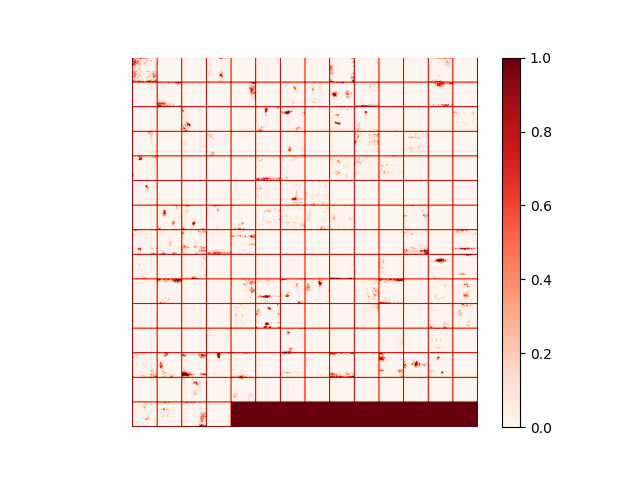

In [105]:
import torchvision

W = model.encoder_nn[0].W_Opt.to(device='cpu')
W = W.view(-1,1,100,100)
W = W.repeat(1,3,1,1)
W_vis = torchvision.utils.make_grid(W, padding=4, pad_value=1, nrow=14)
plt.figure()
plt.imshow(W_vis[0,:,:].detach().numpy(), cmap="Reds")
plt.axis("off")
plt.colorbar()
plt.show()
#plt.savefig(f"./figures/publish/fcs_0_weights.svg", dpi=300, format="svg")

In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
